In [ ]:
# Instal library yang diperlukan untuk proyek
!pip install torch torchvision torchsummary --quiet
# instalasi library

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 73.2 MB/s eta 0:00:00


In [1]:
# Import library yang diperlukan
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import zipfile
import shutil
import cv2
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [2]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Unzip dataset dari Google Drive ke lingkungan Colab
!unzip -q "/content/drive/MyDrive/Dataset dan Model/TB Chest X-ray database.zip" -d "/content/TB_dataset"

In [4]:
# Definisikan base path untuk dataset yang sudah di-unzip
base_path = "/content/TB_dataset/TB_Chest_Radiography_Database"

# Cek path yang digunakan
print(f"Dataset path: {base_path}")

# Verifikasi isi dataset
print("isi dataset")
!ls "/content/TB_dataset"
print("Folder kelas:")
!ls "/content/TB_dataset/TB_Chest_Radiography_Database"

Dataset path: /content/TB_dataset/TB_Chest_Radiography_Database
isi dataset
TB_Chest_Radiography_Database
Folder kelas:
Normal		      README.md.txt  Tuberculosis.metadata.xlsx
Normal.metadata.xlsx  Tuberculosis


In [5]:
# Fungsi untuk mengatur seed agar dapat direproduksi di berbagai library
def set_seed(seed=42):
    """
    Mengatur seed random untuk reproducibility di module numpy, torch, dan random.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Atur seed untuk hasil yang konsisten
set_seed(42)

Statistik Dataset:
Total gambar: 4200
Jumlah gambar Normal: 3500 (83.33%)
Jumlah gambar TB: 700 (16.67%)
Rasio class imbalance: 5.00:1 (Normal:TB)


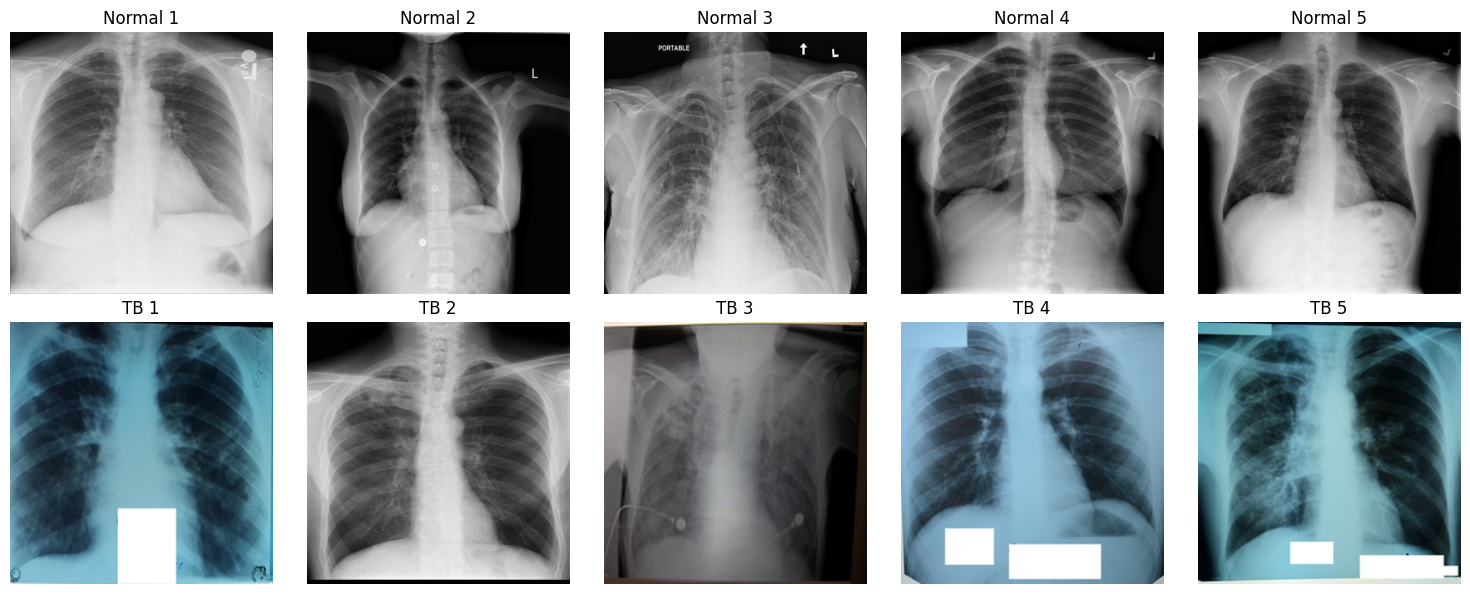

In [6]:
# Definisikan direktori untuk gambar Normal dan Tuberculosis
normal_dir = os.path.join(base_path, "Normal")
tb_dir = os.path.join(base_path, "Tuberculosis")

# Daftar file gambar dan hitung jumlahnya untuk setiap kelas
normal_imgs = [f for f in os.listdir(normal_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
tb_imgs = [f for f in os.listdir(tb_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

num_normal = len(normal_imgs)
num_tb = len(tb_imgs)
total_images = num_normal + num_tb

# Cetak statistik dataset
print(f"Statistik Dataset:")
print(f"Total gambar: {total_images}")
print(f"Jumlah gambar Normal: {num_normal} ({num_normal/total_images*100:.2f}%)")
print(f"Jumlah gambar TB: {num_tb} ({num_tb/total_images*100:.2f}%)")
print(f"Rasio class imbalance: {num_normal/num_tb:.2f}:1 (Normal:TB)")

# Tampilkan sampel gambar dari setiap kelas
plt.figure(figsize=(15, 6))

# Sampel gambar Normal
for i in range(5):
    if i < len(normal_imgs):
        plt.subplot(2, 5, i+1)
        img_path = os.path.join(normal_dir, normal_imgs[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB
        plt.imshow(img)
        plt.title(f"Normal {i+1}")
        plt.axis('off')

# Sampel gambar TB
for i in range(5):
    if i < len(tb_imgs):
        plt.subplot(2, 5, i+6)
        img_path = os.path.join(tb_dir, tb_imgs[i])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Konversi BGR ke RGB
        plt.imshow(img)
        plt.title(f"TB {i+1}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [7]:
# Definisikan kelas augmentasi khusus untuk citra medis
class RandomGamma(torch.nn.Module):
    """
    Menerapkan koreksi gamma secara acak pada citra input.
    Berguna untuk mensimulasikan variasi pencahayaan pada citra X-ray.

    Args:
        gamma_range (tuple): Rentang nilai gamma (min, max).
    """
    def __init__(self, gamma_range=(0.8, 1.2)):
        super().__init__()
        self.gamma_range = gamma_range

    def forward(self, img):
        """
        Menerapkan koreksi gamma.

        Args:
            img (Tensor): Tensor citra input.

        Returns:
            Tensor: Tensor citra setelah menerapkan koreksi gamma (atau yang asli jika tidak diterapkan).
        """
        if torch.rand(1).item() > 0.5:  # 50% kemungkinan untuk diterapkan
            gamma = random.uniform(self.gamma_range[0], self.gamma_range[1])
            return torch.pow(img, gamma)
        return img

Contoh augmentasi pada gambar Normal:


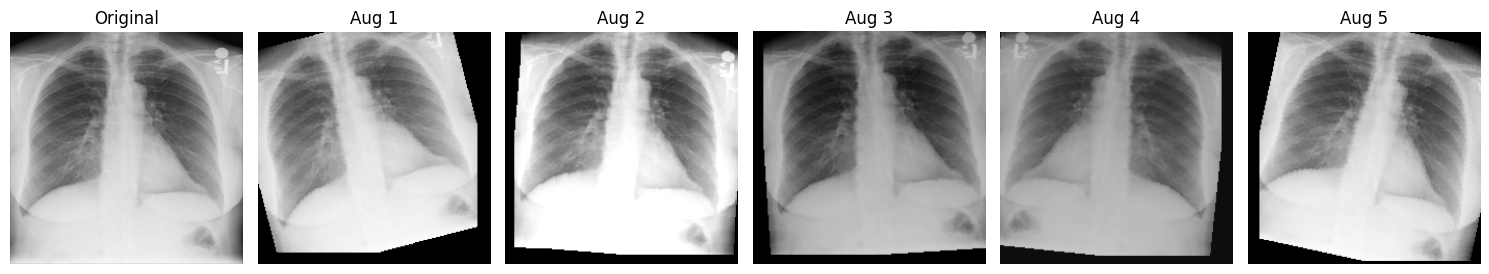

Contoh augmentasi pada gambar TB :


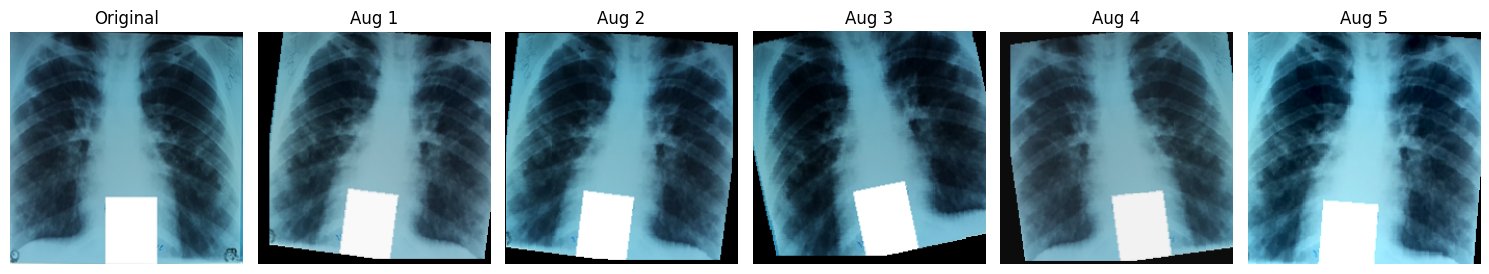

In [12]:
# Fungsi untuk memvisualisasikan efek augmentasi yang diterapkan pada sampel gambar
def visualize_augmentations(image_path, transform, num_samples=5):
    """
    Menampilkan hasil penerapan augmentasi pada sampel gambar.

    Args:
        image_path (str): Path ke gambar asli.
        transform (callable): Transformasi yang akan diterapkan.
        num_samples (int): Jumlah sampel augmentasi yang akan ditampilkan.
    """
    # Baca gambar asli
    original_img = Image.open(image_path).convert('RGB')

    plt.figure(figsize=(15, 4))

    # Tampilkan gambar asli
    plt.subplot(1, num_samples+1, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis('off')

    # Tampilkan sampel augmentasi
    for i in range(num_samples):
        # Terapkan transformasi
        augmented_img = transform(original_img)

        # Konversi tensor ke numpy untuk visualisasi
        if isinstance(augmented_img, torch.Tensor):

            augmented_img_np = np.clip(augmented_img.permute(1, 2, 0).numpy(), 0, 1) # CHW -> HWC

        elif isinstance(augmented_img, Image.Image):
             # Jika transformasi menghasilkan PIL Image, konversi langsung
             augmented_img_np = augmented_img

        plt.subplot(1, num_samples+1, i+2)
        plt.imshow(augmented_img_np)
        plt.title(f"Aug {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Definisikan transformasi citra untuk training dan testing
def get_transforms():
    """
    Mendefinisikan dan mengembalikan pipeline transformasi citra untuk training dan testing.
    Termasuk berbagai augmentasi untuk training.
    """
    # Transformasi training dengan augmentasi
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.05, 0.05),
            scale=(0.95, 1.05)
        ),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
        transforms.RandomAutocontrast(p=0.2),
        transforms.ToTensor(), # Konversi PIL Image ke Tensor (rentang [0, 1])
        RandomGamma(gamma_range=(0.8, 1.2)), # Terapkan RandomGamma kustom
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalisasi dengan statistik ImageNet
                             std=[0.229, 0.224, 0.225]),
        transforms.RandomErasing( # Terapkan Random Erasing
            p=0.2,
            scale=(0.02, 0.05)
        )
    ])

    # Transformasi testing (tanpa augmentasi, hanya resize, toTensor, normalize)
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(), # Konversi PIL Image ke Tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], # Normalisasi dengan statistik ImageNet
                             std=[0.229, 0.224, 0.225])
    ])

    return train_transform, test_transform

# Dapatkan transformasi yang didefinisikan
train_transform, test_transform = get_transforms()

# Visualisasikan augmentasi pada sampel gambar dari setiap kelas
if len(normal_imgs) > 0:
    normal_img_path = os.path.join(normal_dir, normal_imgs[0])
    print("Contoh augmentasi pada gambar Normal:")
    viz_base_transform = transforms.Compose([
        t for t in train_transform.transforms
        if not isinstance(t, transforms.Normalize) and not isinstance(t, transforms.RandomErasing) # Juga kecualikan RandomErasing untuk visualisasi dasar
    ])
    visualize_augmentations(normal_img_path, viz_base_transform)

if len(tb_imgs) > 0:
    tb_img_path = os.path.join(tb_dir, tb_imgs[0])
    print("Contoh augmentasi pada gambar TB :")
    viz_enhanced_transform = transforms.Compose([
        t for t in train_transform.transforms
        if not isinstance(t, transforms.Normalize) and not isinstance(t, transforms.RandomErasing) # Juga kecualikan RandomErasing
    ])
    visualize_augmentations(tb_img_path, viz_enhanced_transform)

In [13]:
# Preprocess dataset dan bagi menjadi set training, validasi, dan testing
# Tentukan lokasi dataset
normal_dir = os.path.join(base_path, "Normal")
tb_dir = os.path.join(base_path, "Tuberculosis")

# Kumpulkan semua path gambar untuk kedua kelas
normal_paths = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
tb_paths = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Gabungkan path dan buat label yang sesuai (0 untuk Normal, 1 untuk Tuberculosis)
all_paths = normal_paths + tb_paths
all_labels = [0]*len(normal_paths) + [1]*len(tb_paths)

# Split pertama: Pisahkan data test (80% train+val, 20% test)
train_val_paths, test_paths, train_val_labels, test_labels = train_test_split(
    all_paths,
    all_labels,
    test_size=0.2,            # 20% data untuk testing
    stratify=all_labels,      # Memastikan distribusi kelas seimbang
    random_state=42           # Untuk reproducibility
)

# Split kedua: Bagi data train+val menjadi set train dan validasi
# (80% dari 80% = 64% train, 20% dari 80% = 16% val)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths,
    train_val_labels,
    test_size=0.2,            # 20% dari train+val untuk validasi
    stratify=train_val_labels, # Memastikan distribusi kelas seimbang
    random_state=42           # Untuk reproducibility
)

# Tampilkan jumlah sampel di setiap split
print(f"Jumlah sampel training: {len(train_paths)}")
print(f"Jumlah sampel validasi: {len(val_paths)}")
print(f"Jumlah sampel testing: {len(test_paths)}")

# Tampilkan distribusi kelas di setiap split
print(f"Distribusi kelas - Training: Normal={train_labels.count(0)}, TB={train_labels.count(1)}")
print(f"Distribusi kelas - Validasi: Normal={val_labels.count(0)}, TB={val_labels.count(1)}")
print(f"Distribusi kelas - Testing: Normal={test_labels.count(0)}, TB={test_labels.count(1)}")

# Hitung dan tampilkan rasio kelas untuk setiap split
train_ratio = train_labels.count(0) / train_labels.count(1) if train_labels.count(1) > 0 else float('inf')
val_ratio = val_labels.count(0) / val_labels.count(1) if val_labels.count(1) > 0 else float('inf')
test_ratio = test_labels.count(0) / test_labels.count(1) if test_labels.count(1) > 0 else float('inf')

print(f"Rasio Normal:TB - Training: {train_ratio:.2f}:1")
print(f"Rasio Normal:TB - Validasi: {val_ratio:.2f}:1")
print(f"Rasio Normal:TB - Testing: {test_ratio:.2f}:1")

Jumlah sampel training: 2688
Jumlah sampel validasi: 672
Jumlah sampel testing: 840
Distribusi kelas - Training: Normal=2240, TB=448
Distribusi kelas - Validasi: Normal=560, TB=112
Distribusi kelas - Testing: Normal=700, TB=140
Rasio Normal:TB - Training: 5.00:1
Rasio Normal:TB - Validasi: 5.00:1
Rasio Normal:TB - Testing: 5.00:1


In [14]:
# Definisikan base directory untuk folder split baru
split_base_dir = "/content/TB_dataset_split"

# Buat direktori untuk setiap split (train, val, test)
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Buat subdirektori untuk setiap kelas (Normal, Tuberculosis) di dalam setiap split
train_normal_dir = os.path.join(train_dir, "Normal")
train_tb_dir = os.path.join(train_dir, "Tuberculosis")
val_normal_dir = os.path.join(val_dir, "Normal")
val_tb_dir = os.path.join(val_dir, "Tuberculosis")
test_normal_dir = os.path.join(test_dir, "Normal")
test_tb_dir = os.path.join(test_dir, "Tuberculosis")

# Daftar semua direktori yang akan dibuat
dirs_to_create = [
    train_normal_dir, train_tb_dir,
    val_normal_dir, val_tb_dir,
    test_normal_dir, test_tb_dir
]

# Buat direktori jika belum ada
for dir_path in dirs_to_create:
    os.makedirs(dir_path, exist_ok=True)

print(f"Direktori split dibuat di bawah: {split_base_dir}")

Direktori split dibuat di bawah: /content/TB_dataset_split


In [15]:
# Fungsi untuk menyalin file dari path asli ke direktori split baru
def copy_files(image_paths, labels, base_dest_dir):
    """
    Menyalin gambar dari daftar path ke direktori tujuan berdasarkan labelnya.

    Args:
        image_paths (list): Daftar path file gambar sumber.
        labels (list): Daftar label yang sesuai (0 atau 1).
        base_dest_dir (str): Base directory tujuan untuk split (misalnya, train_dir).
    """
    for img_path, label in tqdm(zip(image_paths, labels), total=len(image_paths), desc=f"Menyalin ke {os.path.basename(base_dest_dir)}"):
        # Tentukan subdirektori tujuan berdasarkan label
        class_folder = "Tuberculosis" if label == 1 else "Normal"
        dest_dir = os.path.join(base_dest_dir, class_folder)

        # Ambil nama file dari path sumber
        filename = os.path.basename(img_path)

        # Buat path tujuan lengkap
        dest_path = os.path.join(dest_dir, filename)

        # Salin file
        shutil.copy(img_path, dest_path)

# Salin file untuk setiap split (training, validasi, testing) ke direktori masing-masing
print("Menyalin file training...")
copy_files(train_paths, train_labels, train_dir)

print("\nMenyalin file validasi...")
copy_files(val_paths, val_labels, val_dir)

print("\nMenyalin file testing...")
copy_files(test_paths, test_labels, test_dir)

print("\nPenyalinan file selesai.")

# Verifikasi jumlah file yang disalin ke setiap direktori
print("\nMemverifikasi jumlah file di direktori baru:")
print(f"Train Normal: {len(os.listdir(train_normal_dir))}")
print(f"Train TB: {len(os.listdir(train_tb_dir))}")
print(f"Val Normal: {len(os.listdir(val_normal_dir))}")
print(f"Val TB: {len(os.listdir(val_tb_dir))}")
print(f"Test Normal: {len(os.listdir(test_normal_dir))}")
print(f"Test TB: {len(os.listdir(test_tb_dir))}")

Menyalin file training...


Menyalin ke train: 100%|██████████| 2688/2688 [00:07<00:00, 368.43it/s]



Menyalin file validasi...


Menyalin ke val: 100%|██████████| 672/672 [00:00<00:00, 4434.79it/s]



Menyalin file testing...


Menyalin ke test: 100%|██████████| 840/840 [00:00<00:00, 885.45it/s] 


Penyalinan file selesai.

Memverifikasi jumlah file di direktori baru:
Train Normal: 2240
Train TB: 448
Val Normal: 560
Val TB: 112
Test Normal: 700
Test TB: 140


In [ ]:
# Definisikan direktori sumber (dataset split) dan direktori tujuan di Google Drive
source_dir = "/content/TB_dataset_split"
destination_dir = "/content/drive/MyDrive/Dataset dan Model" # Anda dapat mengubah nama folder tujuan jika mau

# Gunakan shell command untuk menyalin seluruh direktori secara rekursif
# -r: recursive copy (menyalin direktori dan isinya)
# -v: verbose (menampilkan file yang sedang disalin)
!cp -rv "{source_dir}" "{destination_dir}"

print(f"\nSelesai menyalin {source_dir} ke {destination_dir}")

In [16]:
class TBDataset(Dataset):
    """
    Kelas Dataset kustom untuk memuat gambar TB Chest X-ray.

    Args:
        image_paths (list): Daftar path ke file gambar.
        labels (list): Daftar label yang sesuai (0 untuk Normal, 1 untuk TB).
        transform (callable, opsional): Transformasi opsional yang akan diterapkan pada gambar.
    """
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self): # Mengembalikan total jumlah sampel dalam dataset
        return len(self.image_paths)

    def __getitem__(self, idx): # Mengambil sampel data tertentu (gambar dan label) berdasarkan indeksnya
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB') # Muat gambar dan konversi ke RGB

        if self.transform:
            image = self.transform(image) # Terapkan transformasi jika ada

        return image, label

In [17]:
# Fungsi untuk membuat weighted random sampler untuk menangani ketidakseimbangan kelas
def create_weighted_sampler(labels):
    """
    Membuat WeightedRandomSampler berdasarkan distribusi kelas untuk menyeimbangkan data training.

    Args:
        labels (list atau Tensor): Daftar atau Tensor label kelas.

    Returns:
        WeightedRandomSampler: Sampler yang memberikan bobot lebih tinggi pada sampel kelas minoritas.
    """
    # Pastikan labels adalah list
    labels = list(labels)
    # Hitung jumlah kemunculan setiap kelas
    class_counts = [labels.count(0), labels.count(1)]
    # Hitung bobot berbanding terbalik dengan frekuensi kelas
    # Kelas minoritas (TB) akan memiliki bobot lebih tinggi untuk menyeimbangkan data
    weights = [1/class_counts[label] for label in labels]
    # Buat sampler yang melakukan sampling dengan penggantian berdasarkan bobot ini
    return WeightedRandomSampler(weights, len(weights), replacement=True)


# Definisikan base directory untuk dataset split
split_base_dir = "/content/TB_dataset_split"

# Definisikan direktori untuk setiap split
train_dir = os.path.join(split_base_dir, "train")
val_dir = os.path.join(split_base_dir, "val")
test_dir = os.path.join(split_base_dir, "test")

# Fungsi untuk mengumpulkan path gambar dan label dari direktori split baru
def collect_paths_and_labels_from_dir(base_dir):
    """
    Mengumpulkan path file gambar dan label yang sesuai dari struktur direktori
    di mana subdirektori merepresentasikan kelas (Normal, Tuberculosis).

    Args:
        base_dir (str): Base directory dari split (misalnya, /content/TB_dataset_split/train).

    Returns:
        tuple: Tuple yang berisi dua list: image_paths (list string) dan labels (list int).
    """
    image_paths = []
    labels = []
    normal_dir = os.path.join(base_dir, "Normal")
    tb_dir = os.path.join(base_dir, "Tuberculosis")

    # Kumpulkan gambar Normal (label 0)
    if os.path.exists(normal_dir):
        normal_paths = [os.path.join(normal_dir, f) for f in os.listdir(normal_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        image_paths.extend(normal_paths)
        labels.extend([0] * len(normal_paths))

    # Kumpulkan gambar TB (label 1)
    if os.path.exists(tb_dir):
        tb_paths = [os.path.join(tb_dir, f) for f in os.listdir(tb_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
        image_paths.extend(tb_paths)
        labels.extend([1] * len(tb_paths))

    # Acak untuk mencampur path Normal dan TB (opsional tapi praktik yang baik)
    combined = list(zip(image_paths, labels))
    random.shuffle(combined)
    image_paths, labels = zip(*combined)
    return list(image_paths), list(labels)

# Dapatkan path gambar dan label dari direktori baru, menggunakan nama variabel asli
train_paths, train_labels = collect_paths_and_labels_from_dir(train_dir)
val_paths, val_labels = collect_paths_and_labels_from_dir(val_dir)
test_paths, test_labels = collect_paths_and_labels_from_dir(test_dir)


# Membuat dataset untuk setiap data split menggunakan path dari direktori baru
train_dataset = TBDataset(
    image_paths=train_paths, # Menggunakan nama variabel asli
    labels=train_labels,     # Menggunakan nama variabel asli
    transform=train_transform  # Terapkan augmentasi dan transformasi training
)

val_dataset = TBDataset(
    image_paths=val_paths,   # Menggunakan nama variabel asli
    labels=val_labels,       # Menggunakan nama variabel asli
    transform=test_transform  # Terapkan transformasi testing (tanpa augmentasi)
)

test_dataset = TBDataset(
    image_paths=test_paths,  # Menggunakan nama variabel asli
    labels=test_labels,      # Menggunakan nama variabel asli
    transform=test_transform  # Terapkan transformasi testing (tanpa augmentasi)
)



# Membuat weighted sampler untuk mengatasi ketidakseimbangan kelas di data training
train_sampler = create_weighted_sampler(train_labels) # Menggunakan label asli untuk sampler

# Membuat DataLoader untuk pemuatan batch yang efisien
batch_size = 128
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    sampler=train_sampler,      # Menggunakan weighted sampler untuk training guna menyeimbangkan kelas
    num_workers=2               # Jumlah proses worker untuk pemuatan data
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,              # Tidak perlu mengacak data validasi
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,              # Tidak perlu mengacak data testing
    num_workers=2
)

# Visualisasi distribusi kelas sebelum dan sesudah penyeimbangan (menggunakan label asli)
print("\nAnalisis penyeimbangan kelas:")

# Distribusi asli dalam dataset training
# Menggunakan variabel label asli untuk mencetak distribusi
orig_normal = train_labels.count(0)
orig_tb = train_labels.count(1)
print(f"Distribusi asli dataset training: Normal={orig_normal}, TB={orig_tb}")
print(f"Rasio: {orig_normal / orig_tb:.2f}:1 (Normal:TB)")


Analisis penyeimbangan kelas:
Distribusi asli dataset training: Normal=2240, TB=448
Rasio: 5.00:1 (Normal:TB)



Analisis penyeimbangan kelas:
Distribusi asli dataset training: Normal=2240, TB=448
Rasio: 5.00:1 (Normal:TB)
Distribusi setelah penyeimbangan (sampling): Normal=1384, TB=1304
Rasio setelah penyeimbangan (sampling): 1.06:1 (Normal:TB)


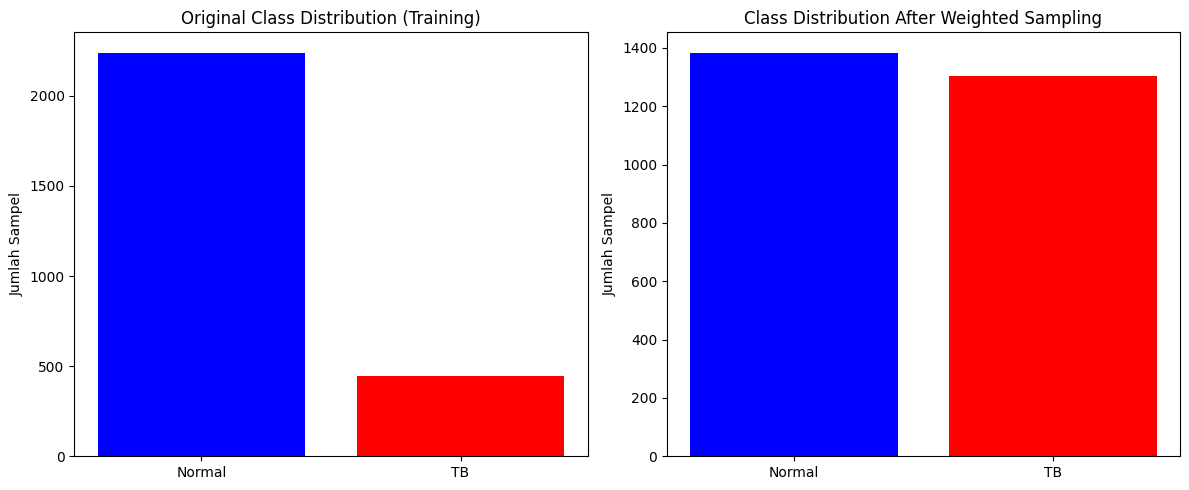


Distribusi kelas dalam 5 batch pertama setelah penyeimbangan:
Batch 1: Normal=72, TB=56, Rasio=1.29:1
Batch 2: Normal=63, TB=65, Rasio=0.97:1
Batch 3: Normal=63, TB=65, Rasio=0.97:1
Batch 4: Normal=70, TB=58, Rasio=1.21:1
Batch 5: Normal=58, TB=70, Rasio=0.83:1


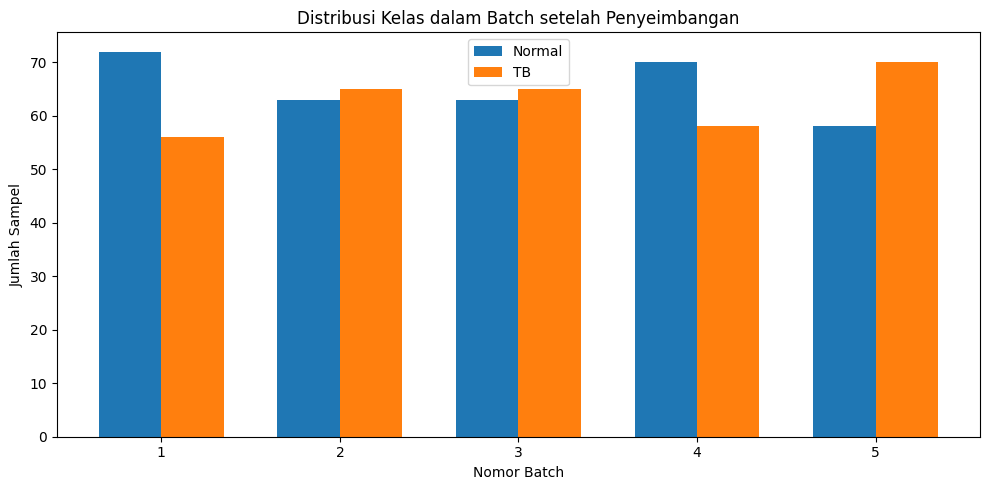

In [18]:
# Visualisasi distribusi kelas sebelum dan sesudah penyeimbangan dan dalam batch
print("\nAnalisis penyeimbangan kelas:")
# Distribusi asli (menggunakan label yang dikumpulkan dari folder train baru)
# Menggunakan nama variabel yang deskriptif
original_normal_count = train_dataset.labels.count(0)
original_tb_count = train_dataset.labels.count(1)
print(f"Distribusi asli dataset training: Normal={original_normal_count}, TB={original_tb_count}")
print(f"Rasio: {original_normal_count / original_tb_count:.2f}:1 (Normal:TB)")

# Simulasikan sampling dengan WeightedRandomSampler untuk melihat efek pada distribusi
sampled_labels = []
num_samples_to_simulate = len(train_dataset) # Sampling sebanyak ini untuk analisis

# Buat iterator dari sampler
sampler_iter = iter(train_sampler)
for _ in range(num_samples_to_simulate):
    try:
        idx = next(sampler_iter)
        # Ambil item untuk mendapatkan label. Catatan: Menggunakan dataset[idx] di sini
        # mungkin menerapkan transformasi, tetapi kita hanya membutuhkan label untuk memeriksa distribusi.
        # Cara yang lebih langsung adalah mengakses train_labels[idx] jika sampler didasarkan pada train_labels.
        # Mari gunakan label dari dataset untuk konsistensi dengan cara data dimuat.
        _, label = train_dataset[idx]
        sampled_labels.append(label)
    except StopIteration:
        break

# Hitung distribusi setelah sampling
sampled_normal_count = sampled_labels.count(0)
sampled_tb_count = sampled_labels.count(1)
print(f"Distribusi setelah penyeimbangan (sampling): Normal={sampled_normal_count}, TB={sampled_tb_count}")
print(f"Rasio setelah penyeimbangan (sampling): {sampled_normal_count / sampled_tb_count:.2f}:1 (Normal:TB)" if sampled_tb_count > 0 else "TB count is 0")


# Visualisasi perbandingan distribusi kelas
plt.figure(figsize=(12, 5))

# Plot distribusi asli
plt.subplot(1, 2, 1)
plt.bar(['Normal', 'TB'], [original_normal_count, original_tb_count], color=['blue', 'red'])
plt.title('Original Class Distribution (Training)')
plt.ylabel('Jumlah Sampel')

# Plot distribusi setelah penyeimbangan (sampling)
plt.subplot(1, 2, 2)
plt.bar(['Normal', 'TB'], [sampled_normal_count, sampled_tb_count], color=['blue', 'red'])
plt.title('Class Distribution After Weighted Sampling')
plt.ylabel('Jumlah Sampel')

plt.tight_layout() # Sesuaikan tata letak untuk mencegah judul tumpang tindih
plt.show()

# Periksa distribusi kelas dalam beberapa batch pertama dari data loader
print("\nDistribusi kelas dalam 5 batch pertama setelah penyeimbangan:")
batch_count = 0
class_dist_in_batches = [] # Menggunakan nama yang lebih deskriptif

for images, labels in train_loader:
    if batch_count >= 5:
        break
    normal_count = torch.sum(labels == 0).item()
    tb_count = torch.sum(labels == 1).item()
    print(f"Batch {batch_count+1}: Normal={normal_count}, TB={tb_count}, Rasio={normal_count/tb_count if tb_count > 0 else float('inf'):.2f}:1")
    class_dist_in_batches.append((normal_count, tb_count))
    batch_count += 1

# Visualisasi distribusi kelas di dalam batch
plt.figure(figsize=(10, 5))
batch_nums = list(range(1, len(class_dist_in_batches) + 1))
normal_counts_batch = [dist[0] for dist in class_dist_in_batches] # Menggunakan nama yang lebih deskriptif
tb_counts_batch = [dist[1] for dist in class_dist_in_batches] # Menggunakan nama yang lebih deskriptif

width = 0.35
plt.bar([i - width/2 for i in batch_nums], normal_counts_batch, width, label='Normal')
plt.bar([i + width/2 for i in batch_nums], tb_counts_batch, width, label='TB')

plt.xlabel('Nomor Batch')
plt.ylabel('Jumlah Sampel')
plt.title('Distribusi Kelas dalam Batch setelah Penyeimbangan')
plt.xticks(batch_nums)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Definisikan arsitektur model ConvNeXt
class ConvNextModel(nn.Module):
    """
    Model ConvNeXt Tiny yang diadaptasi untuk klasifikasi biner.
    Menggunakan ConvNeXt Tiny yang sudah dilatih (pre-trained) sebagai backbone dan mengganti layer classifier terakhir.

    Args:
        num_classes (int): Jumlah kelas output (default adalah 2 untuk Normal/TB).
    """
    def __init__(self, num_classes=2):
        super(ConvNextModel, self).__init__()
        # Gunakan ConvNeXt Tiny yang sudah dilatih (pre-trained) sebagai backbone
        self.convnext = convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT)
        # Ganti layer fully connected terakhir (classifier) agar sesuai dengan jumlah kelas
        in_features = self.convnext.classifier[2].in_features
        self.convnext.classifier[2] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        """
        Forward pass melalui model.

        Args:
            x (Tensor): Tensor citra input.

        Returns:
            Tensor: Logits output dari classifier.
        """
        return self.convnext(x)

In [20]:
# Fungsi untuk melatih model selama satu epoch
def train(model, train_loader, criterion, optimizer, device):
    """
    Melatih model selama satu epoch.

    Args:
        model (nn.Module): Model yang akan dilatih.
        train_loader (DataLoader): DataLoader untuk data training.
        criterion (nn.Module): Fungsi loss.
        optimizer (torch.optim.Optimizer): Optimizer untuk memperbarui bobot model.
        device (torch.device): Device yang digunakan untuk training ('cuda' atau 'cpu').

    Returns:
        tuple: Rata-rata loss epoch dan akurasi epoch.
    """
    model.train() # Atur model ke mode training
    running_loss = 0.0
    correct = 0
    total = 0

    # Buat progress bar untuk loop training
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader),
                        desc="Training", leave=False)

    for batch_idx, (images, labels) in progress_bar:
        # Pindahkan data ke device yang ditentukan
        images, labels = images.to(device), labels.to(device)

        # Nolkan gradien parameter model
        optimizer.zero_grad()

        # Forward pass: hitung output prediksi dengan memberikan input ke model
        outputs = model(images)
        # Hitung loss
        loss = criterion(outputs, labels)

        # Backward pass: hitung gradien loss terhadap parameter model
        loss.backward()
        # Lakukan satu langkah optimasi (pembaruan parameter)
        optimizer.step()

        # Perbarui statistik
        running_loss += loss.item() # Tambahkan loss batch ke running loss
        # Dapatkan indeks probabilitas log maksimum
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0) # Perbarui total jumlah sampel
        correct += (predicted == labels).sum().item() # Perbarui jumlah sampel yang diprediksi dengan benar

        # Perbarui progress bar dengan loss dan akurasi saat ini
        progress_bar.set_postfix({
            'loss': running_loss/(batch_idx+1),
            'acc': f"{100 * correct / total:.2f}%",
            'batch': f"{batch_idx+1}/{len(train_loader)}"
        })

    # Hitung rata-rata loss dan akurasi untuk epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total

    return epoch_loss, epoch_acc

In [21]:
# Fungsi untuk mengevaluasi model pada dataset (validasi atau test)
def evaluate(model, data_loader, criterion, device):
    """
    Mengevaluasi model pada dataset yang diberikan.

    Args:
        model (nn.Module): Model yang akan dievaluasi.
        data_loader (DataLoader): DataLoader untuk data evaluasi (validasi atau test).
        criterion (nn.Module): Fungsi loss.
        device (torch.device): Device yang digunakan untuk evaluasi ('cuda' atau 'cpu').

    Returns:
        tuple: Rata-rata loss epoch, akurasi keseluruhan, akurasi kelas normal,
               akurasi kelas TB, daftar semua prediksi, daftar semua label sebenarnya.
    """
    model.eval() # Atur model ke mode evaluasi
    running_loss = 0.0
    correct = 0
    total = 0

    # Variabel untuk akurasi per kelas
    class_correct = [0, 0]  # Untuk kelas Normal (0) dan TB (1)
    class_total = [0, 0]

    all_preds = [] # Daftar untuk menyimpan semua prediksi
    all_labels = [] # Daftar untuk menyimpan semua label sebenarnya

    # Buat progress bar untuk loop evaluasi
    progress_bar = tqdm(enumerate(data_loader), total=len(data_loader),
                       desc="Evaluating", leave=False)

    # Nonaktifkan perhitungan gradien untuk evaluasi
    with torch.no_grad():
        for batch_idx, (images, labels) in progress_bar:
            # Pindahkan data ke device yang ditentukan
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            # Hitung loss
            loss = criterion(outputs, labels)

            # Perbarui running loss
            running_loss += loss.item()
            # Dapatkan indeks kelas prediksi
            _, predicted = torch.max(outputs.data, 1)

            # Simpan prediksi dan label
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Perbarui statistik akurasi keseluruhan
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Hitung akurasi per kelas
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1

            # Perbarui progress bar dengan loss dan akurasi saat ini
            progress_bar.set_postfix({
                'loss': running_loss/(batch_idx+1),
                'acc': f"{100 * correct / total:.2f}%",
                'batch': f"{batch_idx+1}/{len(data_loader)}"
            })

    # Hitung rata-rata loss dan akurasi keseluruhan untuk dataset
    avg_loss = running_loss / len(data_loader)
    overall_acc = 100 * correct / total

    # Hitung akurasi per kelas (tangani pembagian dengan nol)
    normal_acc = 100 * class_correct[0] / class_total[0] if class_total[0] > 0 else 0
    tb_acc = 100 * class_correct[1] / class_total[1] if class_total[1] > 0 else 0

    return avg_loss, overall_acc, normal_acc, tb_acc, all_preds, all_labels

In [22]:
# Fungsi untuk menghitung berbagai metrik evaluasi
def compute_metrics(all_preds, all_labels):
    """
    Menghitung metrik klasifikasi dan confusion matrix.

    Args:
        all_preds (list): Daftar label prediksi.
        all_labels (list): Daftar label sebenarnya.

    Returns:
        dict: Dictionary yang berisi accuracy, precision, recall, F1-score, dan confusion matrix.
    """
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

    # Hitung Accuracy: persentase sampel yang diprediksi dengan benar dari total prediksi
    accuracy = accuracy_score(all_labels, all_preds)
    # Hitung Precision: kemampuan classifier untuk tidak melabeli sebagai positif sampel yang negatif
    # zero_division=0 menangani kasus di mana tidak ada prediksi positif
    precision = precision_score(all_labels, all_preds, zero_division=0)
    # Hitung Recall: kemampuan classifier untuk menemukan semua sampel positif
    # zero_division=0 menangani kasus di mana tidak ada sampel positif sebenarnya
    recall = recall_score(all_labels, all_preds, zero_division=0)
    # Hitung F1-score: rata-rata harmonik dari precision dan recall
    f1 = f1_score(all_labels, all_preds, zero_division=0)
    # Hitung Confusion Matrix: tabel yang merangkum hasil klasifikasi
    cm = confusion_matrix(all_labels, all_preds)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': cm
    }

In [23]:
# Inisialisasi model dan atur device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Menggunakan device: {device}")

# Inisialisasi model ConvNeXt untuk kedua optimizer dan pindahkan ke device
model_adam = ConvNextModel(num_classes=2).to(device)
model_adamw = ConvNextModel(num_classes=2).to(device)

Menggunakan device: cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 157MB/s]


In [24]:
# Definisikan fungsi loss dan optimizer
# Fungsi loss untuk tugas klasifikasi
criterion = nn.CrossEntropyLoss()

# Optimizer Adam untuk model_adam dengan learning rate tertentu
optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=0.0001)

# Optimizer AdamW untuk model_adamw (menggunakan learning rate default atau dapat ditentukan)
optimizer_adamw = torch.optim.AdamW(model_adamw.parameters())

In [25]:
# Loop training untuk model dengan optimizer Adam
num_epochs = 8 # Definisikan jumlah epoch untuk melatih

# Dictionary untuk menyimpan riwayat training dan metrik untuk model_adam
history_adam = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],      # Metrik loss validasi
    'val_acc': [],       # Metrik akurasi validasi
    'val_normal_acc': [], # Akurasi kelas Normal pada set validasi
    'val_tb_acc': [],    # Akurasi kelas TB pada set validasi
    'test_loss': [],     # Metrik loss test (ditambahkan di akhir atau early stop)
    'test_acc': [],      # Metrik akurasi test (ditambahkan di akhir atau early stop)
    'normal_acc': [],    # Akurasi kelas Normal pada set test (ditambahkan di akhir atau early stop)
    'tb_acc': []         # Akurasi kelas TB pada set test (ditambahkan di akhir atau early stop)
}

print("\n" + "="*50)
print("Training ConvNeXt dengan optimizer Adam")
print("="*50)

# Variabel early stopping
best_val_acc = 0 # Inisialisasi akurasi validasi terbaik yang ditemukan sejauh ini
patience = 3     # Jumlah epoch untuk menunggu peningkatan sebelum berhenti
patience_counter = 0 # Penghitung untuk epoch tanpa peningkatan

# Loop melalui epoch
for epoch in range(num_epochs):
    # Lakukan training untuk satu epoch
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model_adam, train_loader, criterion, optimizer_adam, device)

    # Lakukan validasi setelah epoch training
    print("Melakukan validasi...")
    val_loss, val_acc, val_normal_acc, val_tb_acc, val_preds, val_labels = evaluate(
        model_adam, val_loader, criterion, device)

    # Tentukan apakah evaluasi test harus dilakukan (hanya di epoch terakhir atau saat early stopping)
    do_test_eval = (epoch == num_epochs - 1) or (patience_counter >= patience)

    if do_test_eval:
        print("Mengevaluasi pada data testing...")
        test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
            model_adam, test_loader, criterion, device)
    else:
        # Atur metrik test ke None jika tidak mengevaluasi pada set test di epoch ini
        test_loss, test_acc, normal_acc, tb_acc = None, None, None, None
        all_preds, all_labels = None, None

    # Simpan metrik dalam dictionary history
    history_adam['train_loss'].append(train_loss)
    history_adam['train_acc'].append(train_acc)
    history_adam['val_loss'].append(val_loss)
    history_adam['val_acc'].append(val_acc)
    history_adam['val_normal_acc'].append(val_normal_acc)
    history_adam['val_tb_acc'].append(val_tb_acc)

    # Hanya tambahkan metrik test jika evaluasi test dilakukan
    if do_test_eval:
        history_adam['test_loss'].append(test_loss)
        history_adam['test_acc'].append(test_acc)
        history_adam['normal_acc'].append(normal_acc)
        history_adam['tb_acc'].append(tb_acc)

    # Tampilkan statistik epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Normal Acc: {val_normal_acc:.2f}%, Val TB Acc: {val_tb_acc:.2f}%")

    # Tampilkan statistik test jika evaluasi test dilakukan
    if do_test_eval:
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"Test Normal Acc: {normal_acc:.2f}%, Test TB Acc: {tb_acc:.2f}%")

    print("-" * 50)

    # Cek early stopping: Periksa apakah akurasi validasi meningkat
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Reset penghitung patience jika terlihat peningkatan
        print(f"✓ Akurasi validasi meningkat menjadi {best_val_acc:.2f}%")
        # Simpan state model terbaik berdasarkan akurasi validasi
        torch.save(model_adam.state_dict(), 'convnext_adam_best_model.pth')
    else:
        patience_counter += 1 # Naikkan penghitung patience jika tidak ada peningkatan
        print(f"✗ Tidak ada peningkatan akurasi validasi. Patience: {patience_counter}/{patience}")

    # Jika kriteria early stopping terpenuhi
    if patience_counter >= patience:
        print(f"Early stopping pada epoch {epoch+1}.")

        # Evaluasi model terbaik pada data test jika belum dilakukan
        if not do_test_eval:
            # Muat state dictionary model terbaik
            model_adam.load_state_dict(torch.load('convnext_adam_best_model.pth'))
            print("Mengevaluasi model terbaik pada data testing...")
            test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
                model_adam, test_loader, criterion, device)

            # Simpan hasil evaluasi test di history
            history_adam['test_loss'].append(test_loss)
            history_adam['test_acc'].append(test_acc)
            history_adam['normal_acc'].append(normal_acc)
            history_adam['tb_acc'].append(tb_acc)

            print(f"Model terbaik - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
            print(f"Model terbaik - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")

        break # Keluar dari loop training karena early stopping

# Jika training selesai tanpa early stopping, lakukan evaluasi test akhir
if patience_counter < patience and epoch == num_epochs - 1:
    print("Mengevaluasi pada data testing...")
    test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
        model_adam, test_loader, criterion, device)

    # Tambahkan ke history jika belum ditambahkan oleh do_test_eval
    if test_loss not in history_adam['test_loss']:
        history_adam['test_loss'].append(test_loss)
        history_adam['test_acc'].append(test_acc)
        history_adam['normal_acc'].append(normal_acc)
        history_adam['tb_acc'].append(tb_acc)

    print(f"Hasil akhir - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Hasil akhir - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")


Training ConvNeXt dengan optimizer Adam

Epoch 1/8


Melakukan validasi...


Epoch 1/8
Train Loss: 0.1937, Train Acc: 91.22%
Val Loss: 0.1538, Val Acc: 93.60%
Val Normal Acc: 92.32%, Val TB Acc: 100.00%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 93.60%

Epoch 2/8


Melakukan validasi...


Epoch 2/8
Train Loss: 0.0440, Train Acc: 98.55%
Val Loss: 0.0078, Val Acc: 99.85%
Val Normal Acc: 99.82%, Val TB Acc: 100.00%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 99.85%

Epoch 3/8


Melakukan validasi...


Epoch 3/8
Train Loss: 0.0110, Train Acc: 99.74%
Val Loss: 0.0099, Val Acc: 99.85%
Val Normal Acc: 99.82%, Val TB Acc: 100.00%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 1/3

Epoch 4/8


Melakukan validasi...


Epoch 4/8
Train Loss: 0.0046, Train Acc: 99.93%
Val Loss: 0.0023, Val Acc: 100.00%
Val Normal Acc: 100.00%, Val TB Acc: 100.00%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 100.00%

Epoch 5/8


Melakukan validasi...


Epoch 5/8
Train Loss: 0.0080, Train Acc: 99.78%
Val Loss: 0.0014, Val Acc: 100.00%
Val Normal Acc: 100.00%, Val TB Acc: 100.00%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 1/3

Epoch 6/8


Melakukan validasi...


Epoch 6/8
Train Loss: 0.0045, Train Acc: 99.93%
Val Loss: 0.0139, Val Acc: 99.55%
Val Normal Acc: 99.46%, Val TB Acc: 100.00%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 2/3

Epoch 7/8


Melakukan validasi...


Epoch 7/8
Train Loss: 0.0024, Train Acc: 99.96%
Val Loss: 0.0098, Val Acc: 99.70%
Val Normal Acc: 99.64%, Val TB Acc: 100.00%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 3/3
Early stopping pada epoch 7.
Mengevaluasi model terbaik pada data testing...


Model terbaik - Test Loss: 0.0097, Test Acc: 99.64%
Model terbaik - Normal Acc: 99.86%, TB Acc: 98.57%


In [ ]:
# Loop training untuk model dengan optimizer AdamW
num_epochs = 3 # Definisikan jumlah epoch untuk melatih

# Dictionary untuk menyimpan riwayat training dan metrik untuk model_adamw
history_adamw = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],      # Metrik loss validasi
    'val_acc': [],       # Metrik akurasi validasi
    'val_normal_acc': [], # Akurasi kelas Normal pada set validasi
    'val_tb_acc': [],    # Akurasi kelas TB pada set validasi
    'test_loss': [],     # Metrik loss test (ditambahkan di akhir atau early stop)
    'test_acc': [],      # Metrik akurasi test (ditambahkan di akhir atau early stop)
    'normal_acc': [],    # Akurasi kelas Normal pada set test (ditambahkan di akhir atau early stop)
    'tb_acc': []         # Akurasi kelas TB pada set test (ditambahkan di akhir atau early stop)
}

print("\n" + "="*50)
print("Training ConvNeXt dengan optimizer Adamw")
print("="*50)

# Variabel early stopping
best_val_acc = 0 # Inisialisasi akurasi validasi terbaik yang ditemukan sejauh ini
patience = 3     # Jumlah epoch untuk menunggu peningkatan sebelum berhenti
patience_counter = 0 # Penghitung untuk epoch tanpa peningkatan

# Loop melalui epoch
for epoch in range(num_epochs):
    # Lakukan training untuk satu epoch
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train(model_adamw, train_loader, criterion, optimizer_adamw, device)

    # Lakukan validasi setelah epoch training
    print("Melakukan validasi...")
    val_loss, val_acc, val_normal_acc, val_tb_acc, val_preds, val_labels = evaluate(
        model_adamw, val_loader, criterion, device)

    # Tentukan apakah evaluasi test harus dilakukan (hanya di epoch terakhir atau saat early stopping)
    do_test_eval = (epoch == num_epochs - 1) or (patience_counter >= patience)

    if do_test_eval:
        print("Mengevaluasi pada data testing...")
        test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
            model_adamw, test_loader, criterion, device)
    else:
        # Atur metrik test ke None jika tidak mengevaluasi pada set test di epoch ini
        test_loss, test_acc, normal_acc, tb_acc = None, None, None, None
        all_preds, all_labels = None, None


    # Simpan metrik dalam dictionary history
    history_adamw['train_loss'].append(train_loss)
    history_adamw['train_acc'].append(train_acc)
    history_adamw['val_loss'].append(val_loss)
    history_adamw['val_acc'].append(val_acc)
    history_adamw['val_normal_acc'].append(val_normal_acc)
    history_adamw['val_tb_acc'].append(val_tb_acc)

    # Hanya tambahkan metrik test jika evaluasi test dilakukan
    if do_test_eval:
        history_adamw['test_loss'].append(test_loss)
        history_adamw['test_acc'].append(test_acc)
        history_adamw['normal_acc'].append(normal_acc)
        history_adamw['tb_acc'].append(tb_acc)

    # Tampilkan statistik epoch
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"Val Normal Acc: {val_normal_acc:.2f}%, Val TB Acc: {val_tb_acc:.2f}%")

    # Tampilkan statistik test jika evaluasi test dilakukan
    if do_test_eval:
        print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
        print(f"Test Normal Acc: {normal_acc:.2f}%, Test TB Acc: {tb_acc:.2f}%")

    print("-" * 50)

    # Cek early stopping: Periksa apakah akurasi validasi meningkat
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0 # Reset penghitung patience jika terlihat peningkatan
        print(f"✓ Akurasi validasi meningkat menjadi {best_val_acc:.2f}%")
        # Simpan state model terbaik berdasarkan akurasi validasi
        torch.save(model_adamw.state_dict(), 'convnext_adamw_best_model.pth')
    else:
        patience_counter += 1 # Naikkan penghitung patience jika tidak ada peningkatan
        print(f"✗ Tidak ada peningkatan akurasi validasi. Patience: {patience_counter}/{patience}")

    # Jika kriteria early stopping terpenuhi
    if patience_counter >= patience:
        print(f"Early stopping pada epoch {epoch+1}.")

        # Evaluasi model terbaik pada data test jika belum dilakukan
        if not do_test_eval:
            # Muat state dictionary model terbaik
            model_adamw.load_state_dict(torch.load('convnext_adamw_best_model.pth'))
            print("Mengevaluasi model terbaik pada data testing...")
            test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
                model_adamw, test_loader, criterion, device)

            # Simpan hasil evaluasi test di history
            history_adamw['test_loss'].append(test_loss)
            history_adamw['test_acc'].append(test_acc)
            history_adamw['normal_acc'].append(normal_acc)
            history_adamw['tb_acc'].append(tb_acc)

            print(f"Model terbaik - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
            print(f"Model terbaik - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")

        break # Keluar dari loop training karena early stopping

# Jika training selesai tanpa early stopping, lakukan evaluasi test akhir
if patience_counter < patience and epoch == num_epochs - 1:
    print("Mengevaluasi pada data testing...")
    test_loss, test_acc, normal_acc, tb_acc, all_preds, all_labels = evaluate(
        model_adamw, test_loader, criterion, device)

    # Tambahkan ke history jika belum ditambahkan oleh do_test_eval
    if test_loss not in history_adamw['test_loss']:
        history_adamw['test_loss'].append(test_loss)
        history_adamw['test_acc'].append(test_acc)
        history_adamw['normal_acc'].append(normal_acc)
        history_adamw['tb_acc'].append(tb_acc)

    print(f"Hasil akhir - Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print(f"Hasil akhir - Normal Acc: {normal_acc:.2f}%, TB Acc: {tb_acc:.2f}%")


Training ConvNeXt dengan optimizer Adamw

Epoch 1/3


Melakukan validasi...


Epoch 1/3
Train Loss: 0.6762, Train Acc: 57.85%
Val Loss: 0.4255, Val Acc: 89.73%
Val Normal Acc: 100.00%, Val TB Acc: 38.39%
--------------------------------------------------
✓ Akurasi validasi meningkat menjadi 89.73%

Epoch 2/3


Melakukan validasi...


Epoch 2/3
Train Loss: 0.6081, Train Acc: 67.37%
Val Loss: 0.7413, Val Acc: 17.26%
Val Normal Acc: 0.71%, Val TB Acc: 100.00%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 1/3

Epoch 3/3


Melakukan validasi...


Mengevaluasi pada data testing...


Epoch 3/3
Train Loss: 0.6146, Train Acc: 64.62%
Val Loss: 0.5519, Val Acc: 74.70%
Val Normal Acc: 71.79%, Val TB Acc: 89.29%
Test Loss: 0.5565, Test Acc: 73.45%
Test Normal Acc: 69.71%, Test TB Acc: 92.14%
--------------------------------------------------
✗ Tidak ada peningkatan akurasi validasi. Patience: 2/3
Mengevaluasi pada data testing...


Hasil akhir - Test Loss: 0.5565, Test Acc: 73.45%
Hasil akhir - Normal Acc: 69.71%, TB Acc: 92.14%


In [26]:
# Fungsi untuk memvisualisasikan sejumlah prediksi yang seimbang dari setiap kelas
def visualize_predictions_balanced(model, data_loader, title, num_samples_per_class=5):
    """
    Memvisualisasikan prediksi dengan jumlah sampel yang seimbang per kelas.

    Args:
        model (nn.Module): Model yang sudah dilatih.
        data_loader (DataLoader): DataLoader untuk data yang akan divisualisasikan.
        title (str): Judul untuk plot.
        num_samples_per_class (int): Jumlah sampel yang akan ditampilkan per kelas.
    """
    model.eval() # Atur model ke mode evaluasi

    # Daftar untuk menyimpan gambar dan label untuk visualisasi, dipisahkan berdasarkan kelas
    normal_images = []
    normal_labels = []
    tb_images = []
    tb_labels = []

    # Iterasi melalui data loader untuk mengumpulkan sampel yang seimbang
    for images, labels in data_loader:
        for i in range(len(labels)):
            if labels[i] == 0 and len(normal_images) < num_samples_per_class:
                normal_images.append(images[i])
                normal_labels.append(labels[i])
            elif labels[i] == 1 and len(tb_images) < num_samples_per_class:
                tb_images.append(images[i])
                tb_labels.append(labels[i])

        # Berhenti mengumpulkan setelah kita memiliki cukup sampel untuk setiap kelas
        if len(normal_images) == num_samples_per_class and len(tb_images) == num_samples_per_class:
            break

    # Gabungkan semua sampel yang dikumpulkan
    all_images_list = normal_images + tb_images # Menggunakan nama yang lebih deskriptif
    all_labels_list = normal_labels + tb_labels # Menggunakan nama yang lebih deskriptif

    # Konversi gambar dan label yang dikumpulkan menjadi tensor dan pindahkan ke device
    all_images_tensor = torch.stack(all_images_list).to(device) # Menggunakan nama yang lebih deskriptif
    all_labels_tensor = torch.stack(all_labels_list).to(device) # Menggunakan nama yang lebih deskriptif

    # Dapatkan prediksi dari model (tanpa perhitungan gradien)
    with torch.no_grad():
        outputs = model(all_images_tensor)
        _, preds = torch.max(outputs, 1)

    # Denormalisasi gambar untuk visualisasi yang benar (mengasumsikan normalisasi ImageNet standar)
    # Menggunakan nama variabel yang deskriptif
    imagenet_mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    imagenet_std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    denorm_images = all_images_tensor * imagenet_std + imagenet_mean # Menggunakan nama yang lebih deskriptif
    denorm_images = torch.clamp(denorm_images, 0, 1) # Jepit nilai agar dalam rentang [0, 1]

    # Plot gambar dengan label asli dan prediksi model
    plt.figure(figsize=(15, 6))  # Tinggikan ukuran figure untuk kejelasan
    plt.suptitle(title, y=1.05)  # Sesuaikan posisi judul

    for i in range(len(all_images_tensor)):
        plt.subplot(2, num_samples_per_class, i + 1)  # Atur plot dalam 2 baris (satu untuk setiap kelas)
        img = denorm_images[i].cpu().permute(1, 2, 0).numpy() # Konversi tensor ke numpy (CHW -> HWC)
        plt.imshow(img) # Tampilkan gambar

        # Tentukan label dan warna berdasarkan kebenaran prediksi
        true_label = "TB" if all_labels_tensor[i] else "Normal"
        pred_label = "TB" if preds[i] else "Normal"
        color = "green" if all_labels_tensor[i] == preds[i] else "red" # Hijau untuk benar, Merah untuk salah

        # Atur judul dengan label asli dan label prediksi, diberi warna berdasarkan kebenaran
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off') # Sembunyikan sumbu

    plt.tight_layout() # Sesuaikan tata letak untuk mencegah judul tumpang tindih
    plt.show() # Tampilkan plot


Visualisasi Sample Prediksi (Seimbang):


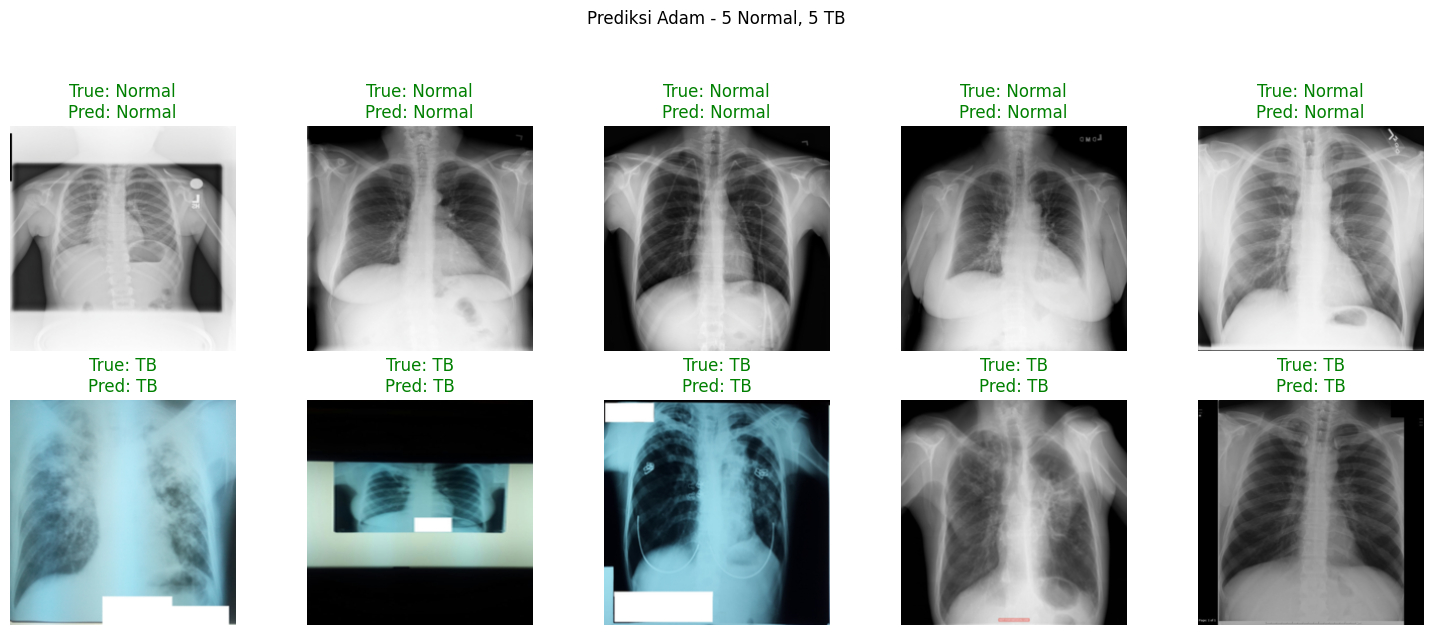

In [27]:
# Visualisasikan sampel prediksi yang seimbang dari set test
print("\nVisualisasi Sample Prediksi (Seimbang):")

# Visualisasikan prediksi untuk model yang dilatih dengan optimizer Adam
visualize_predictions_balanced(model_adam, test_loader, "Prediksi Adam - 5 Normal, 5 TB")
# Opsional, visualisasikan prediksi untuk model yang dilatih dengan optimizer AdamW
# visualize_predictions_balanced(model_adamw, test_loader, "Prediksi AdamW - 5 Normal, 5 TB")

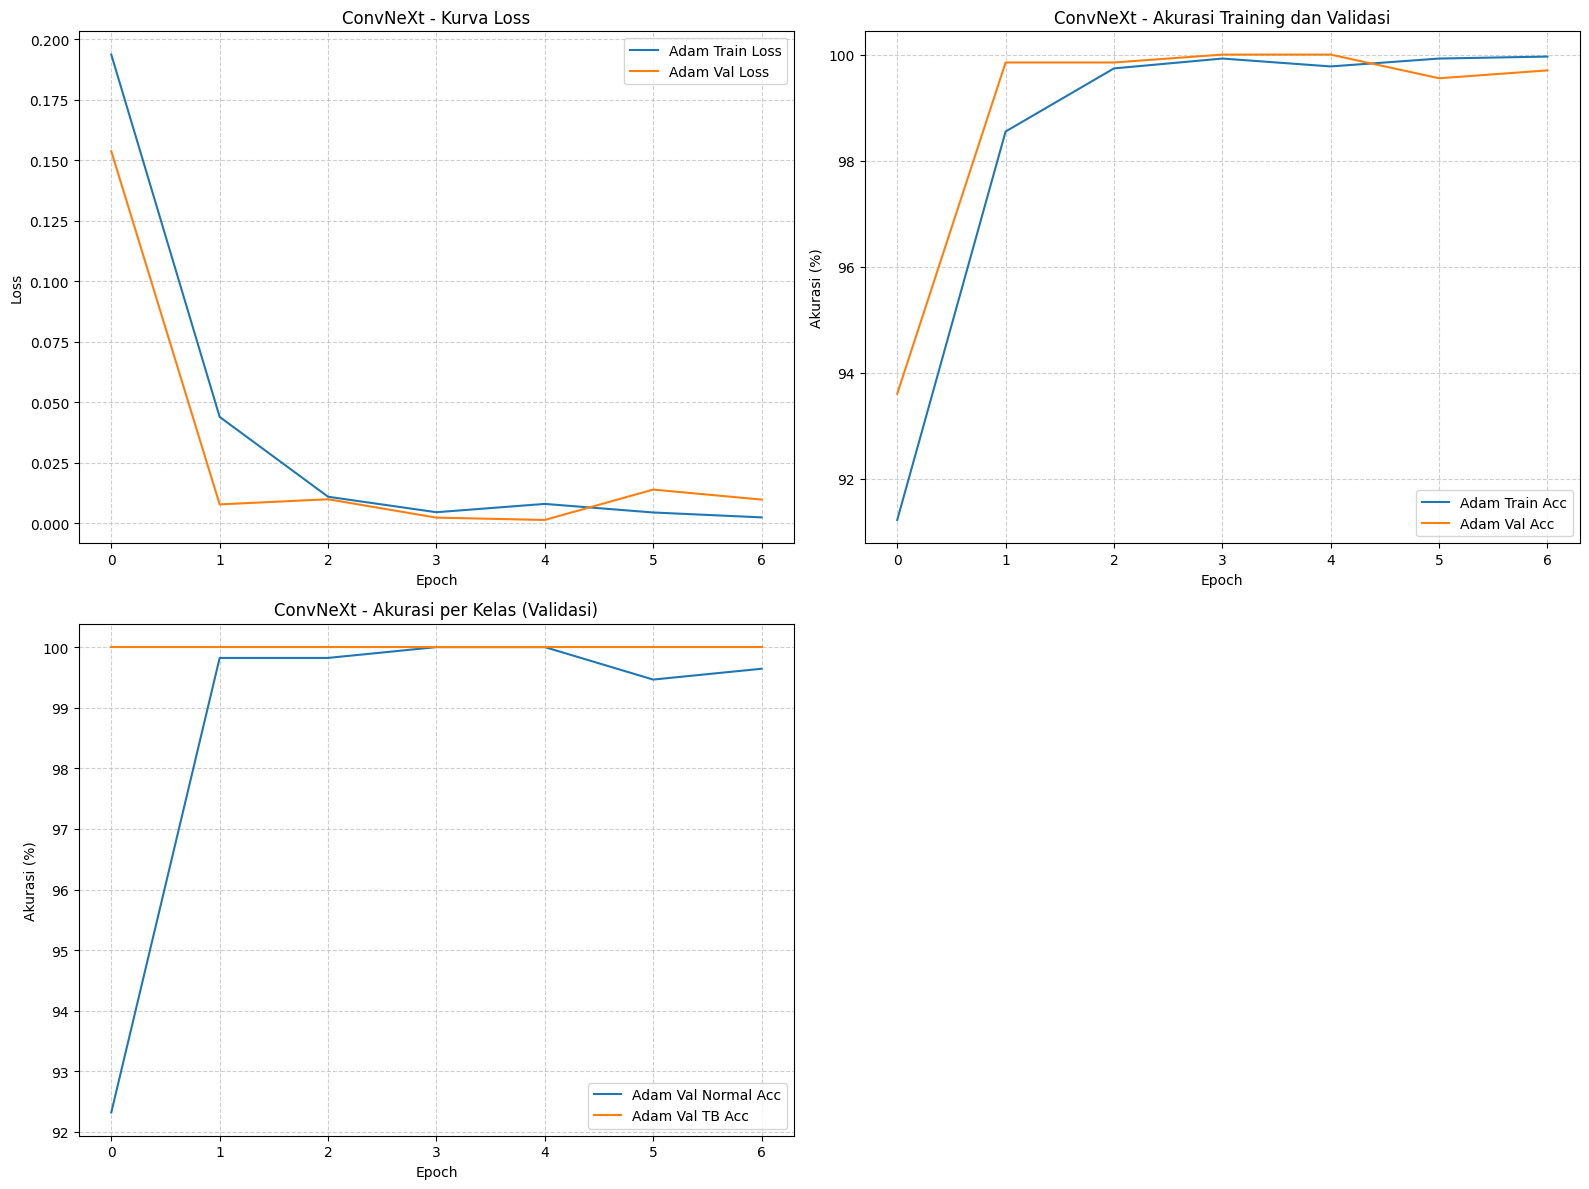

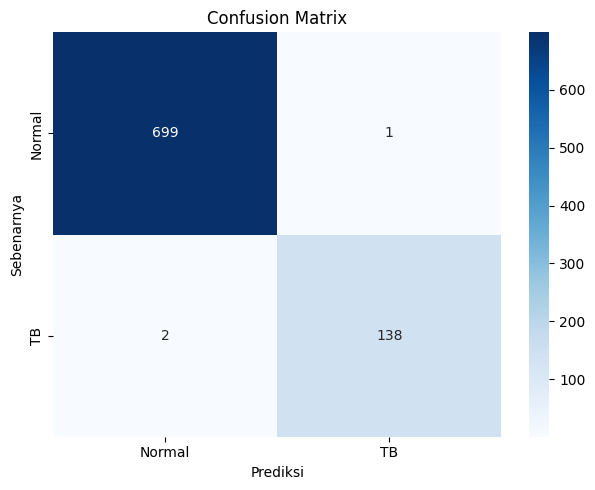


HASIL EVALUASI MODEL

Metrik Evaluasi pada Test Set (Adam):
Accuracy: 0.9964
Precision: 0.9928
Recall: 0.9857
F1-Score: 0.9892

Classification Report - ConvNeXt dengan Optimizer Adam
              precision    recall  f1-score   support

      Normal      0.997     0.999     0.998       700
          TB      0.993     0.986     0.989       140

    accuracy                          0.996       840
   macro avg      0.995     0.992     0.994       840
weighted avg      0.996     0.996     0.996       840



In [28]:
# Membuat visualisasi kurva loss dan akurasi
plt.figure(figsize=(16, 12))

# Plot kurva loss
plt.subplot(2, 2, 1)
plt.plot(history_adam['train_loss'], label='Adam Train Loss')
plt.plot(history_adam['val_loss'], label='Adam Val Loss')
# plt.plot(history_adamw['train_loss'], label='AdamW Train Loss', linestyle='--')
# plt.plot(history_adamw['val_loss'], label='AdamW Val Loss', linestyle='--')
plt.title('ConvNeXt - Kurva Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)


# Plot kurva akurasi training dan validasi
plt.subplot(2, 2, 2)
plt.plot(history_adam['train_acc'], label='Adam Train Acc')
plt.plot(history_adam['val_acc'], label='Adam Val Acc')
# plt.plot(history_adamw['train_acc'], label='AdamW Train Acc', linestyle='--')
# plt.plot(history_adamw['val_acc'], label='AdamW Val Acc', linestyle='--')
plt.title('ConvNeXt - Akurasi Training dan Validasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot akurasi per kelas
plt.subplot(2, 2, 3)
plt.plot(history_adam['val_normal_acc'], label='Adam Val Normal Acc')
plt.plot(history_adam['val_tb_acc'], label='Adam Val TB Acc')
# plt.plot(history_adamw['val_normal_acc'], label='AdamW Val Normal Acc', linestyle='--')
# plt.plot(history_adamw['val_tb_acc'], label='AdamW Val TB Acc', linestyle='--')
plt.title('ConvNeXt - Akurasi per Kelas (Validasi)')
plt.xlabel('Epoch')
plt.ylabel('Akurasi (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.savefig('hasil_training.png')  # Simpan gambar jika diperlukan
plt.show()

# Visualisasi hasil evaluasi dengan confusion matrix
# Evaluasi akhir untuk model dengan Adam
_, _, _, _, all_preds_adam, all_labels_adam = evaluate(model_adam, test_loader, criterion, device)
metrics_adam = compute_metrics(all_preds_adam, all_labels_adam)

# Evaluasi akhir untuk model dengan AdamW
# _, _, _, _, all_preds_adamw, all_labels_adamw = evaluate(model_adamw, test_loader, criterion, device)
# metrics_adamw = compute_metrics(all_preds_adamw, all_labels_adamw)

# Buat confusion matrix untuk model Adam
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
labels = ['Normal', 'TB']
cm = metrics_adam['confusion_matrix']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Sebenarnya')

# Buat confusion matrix untuk model AdamW
# plt.subplot(1, 2, 2)
# cm = metrics_adamw['confusion_matrix']
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
# plt.title('Confusion Matrix - AdamW')
# plt.xlabel('Prediksi')
# plt.ylabel('Sebenarnya')

plt.tight_layout()
plt.savefig('confusion_matrix.png')  # Simpan gambar jika diperlukan
plt.show()

# Tampilkan ringkasan metrik evaluasi
print("\n" + "="*50)
print("HASIL EVALUASI MODEL")
print("="*50)

# Menampilkan metrik evaluasi untuk model Adam
print("\nMetrik Evaluasi pada Test Set (Adam):")
print(f"Accuracy: {metrics_adam['accuracy']:.4f}")
print(f"Precision: {metrics_adam['precision']:.4f}")
print(f"Recall: {metrics_adam['recall']:.4f}")
print(f"F1-Score: {metrics_adam['f1_score']:.4f}")

print("\n" + "="*50)
print("Classification Report - ConvNeXt dengan Optimizer Adam")
print("="*50)
print(classification_report(all_labels_adam, all_preds_adam, target_names=['Normal', 'TB'], digits=3))

Code dibawah digunakan untuk menghitung dan memvisualisasikan Kurva ROC (Receiver Operating Characteristic) dan AUC (Area Under the Curve) untuk model klasifikasi. Kurva ROC menggambarkan trade-off antara True Positive Rate (Recall) dan False Positive Rate pada berbagai threshold klasifikasi. AUC adalah ukuran agregat dari kinerja klasifikasi di seluruh kemungkinan threshold, dengan nilai yang lebih tinggi menunjukkan kinerja yang lebih baik.

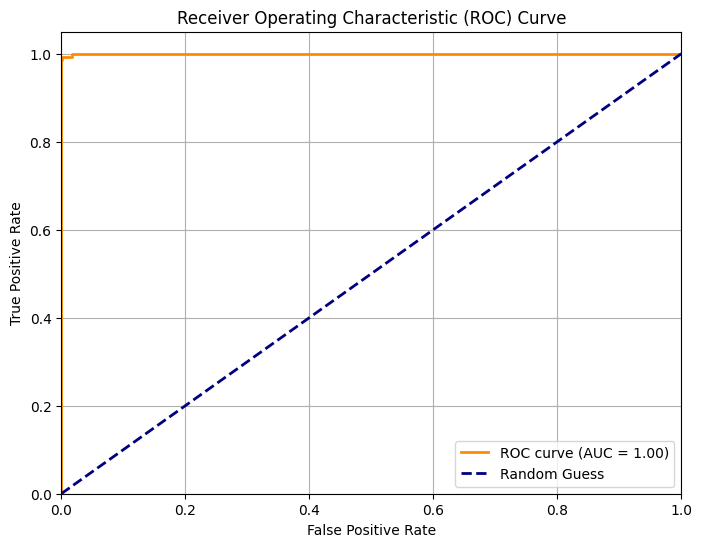

AUC untuk model Adam: 0.9999


In [29]:
from sklearn.metrics import roc_curve, auc

# Dapatkan probabilitas prediksi untuk kelas positif (TB)
# Pastikan model_adam sudah ditraining dan dalam mode evaluasi
model_adam.eval()
all_probs_adam = []
all_labels_adam = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_adam(images)
        # Softmax untuk mendapatkan probabilitas
        probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilitas kelas TB (kelas 1)
        all_probs_adam.extend(probs.cpu().numpy())
        all_labels_adam.extend(labels.cpu().numpy())

# Hitung ROC curve dan AUC
fpr, tpr, thresholds = roc_curve(all_labels_adam, all_probs_adam)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC untuk model Adam: {roc_auc:.4f}")

Code dibawah digunakan untuk menghitung dan memvisualisasikan Kurva Precision-Recall (Precision-Recall Curve). Kurva ini menggambarkan trade-off antara Precision dan Recall pada berbagai *threshold* probabilitas. Sangat berguna terutama pada dataset yang tidak seimbang, karena memberikan pandangan yang lebih informatif tentang kinerja model dibandingkan hanya dengan akurasi keseluruhan. AUC di bawah kurva Precision-Recall (AP) adalah metrik agregat dari kinerja ini.

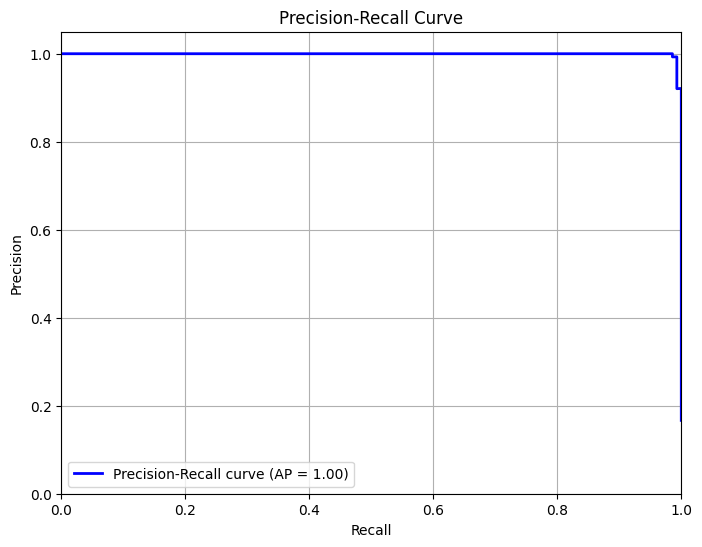

Average Precision (AP) untuk model Adam: 0.9994


In [30]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Gunakan probabilitas prediksi dan label yang sudah didapatkan dari evaluasi sebelumnya
# all_probs_adam dan all_labels_adam

# Hitung Precision-Recall curve dan Average Precision (AP)
precision, recall, _ = precision_recall_curve(all_labels_adam, all_probs_adam)
average_precision = average_precision_score(all_labels_adam, all_probs_adam)

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

print(f"Average Precision (AP) untuk model Adam: {average_precision:.4f}")

Code dibawah digunakan untuk menampilkan gambar dari dataset testing yang salah diklasifikasikan oleh model, beserta nama file gambarnya. Ini membantu dalam memahami jenis kesalahan yang dilakukan model dan area mana yang mungkin perlu perbaikan dengan merujuk langsung pada file gambar aslinya.


Visualisasi Gambar yang Salah Diklasifikasikan (dengan Nama File):


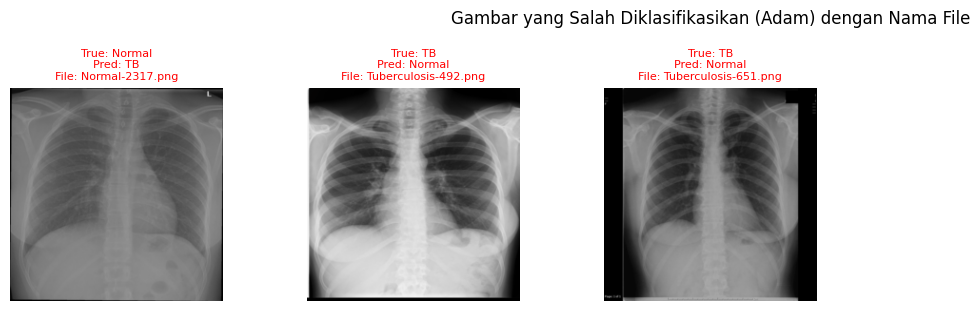

In [39]:
# Menampilkan gambar dengan prediksi yang salah beserta nama filenya
def visualize_misclassified_images_with_filenames(model, data_loader, title, num_samples=10):
    """
    Visualizes misclassified images from a data loader, including filenames.
    """
    model.eval()
    misclassified_info = [] # Store (image, true_label, pred_label, filename)

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            # Find misclassified samples
            incorrect_indices = (preds != labels).nonzero(as_tuple=True)[0]

            dataset = data_loader.dataset # Access the underlying dataset
            if not hasattr(dataset, 'image_paths'):
                print("Dataset does not have 'image_paths' attribute needed for filenames.")
                # Fallback to visualizing without filenames if paths are not available
                visualize_misclassified_images(model, data_loader, title, num_samples)
                return

            # Collect misclassified samples with their full info
            misclassified_list_full = []
            current_count = 0
            # Iterate through the dataset to find misclassified items
            for i in range(len(dataset)):
                if current_count >= num_samples:
                    break
                image, true_label = dataset[i]
                image = image.unsqueeze(0).to(device) # Add batch dimension
                with torch.no_grad():
                    output = model(image)
                    _, pred_label = torch.max(output, 1)

                if pred_label.item() != true_label:
                    misclassified_list_full.append({
                        'image': dataset[i][0], # Get the image tensor
                        'true_label': true_label,
                        'pred_label': pred_label.item(),
                        'filename': os.path.basename(dataset.image_paths[i]) # Get filename from original path
                    })
                    current_count += 1

            misclassified_images = [item['image'] for item in misclassified_list_full]
            misclassified_labels = [item['true_label'] for item in misclassified_list_full]
            misclassified_preds = [item['pred_label'] for item in misclassified_list_full]
            filenames = [item['filename'] for item in misclassified_list_full]


    if not misclassified_images:
        print(f"Tidak ada gambar yang salah diklasifikasikan dalam sampel yang diperiksa.")
        return

    # Denormalize images (need to stack them first)
    misclassified_images_tensor = torch.stack(misclassified_images)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    denorm_images = misclassified_images_tensor * std + mean
    denorm_images = torch.clamp(denorm_images, 0, 1)

    # Plot images with predictions and filenames
    plt.figure(figsize=(15, int(len(misclassified_images) / 5 + 0.99) * 3)) # Adjust height based on number of images
    plt.suptitle(title, y=1.02)

    for i in range(len(denorm_images)):
        plt.subplot(int(len(denorm_images) / 5 + 0.99) if len(denorm_images) > 5 else 1, 5, i + 1)
        img = denorm_images[i].permute(1, 2, 0).numpy()
        plt.imshow(img)

        true_label_str = "TB" if misclassified_labels[i] else "Normal"
        pred_label_str = "TB" if misclassified_preds[i] else "Normal"

        plt.title(f"True: {true_label_str}\nPred: {pred_label_str}\nFile: {filenames[i]}", color="red", fontsize=8) # Include filename
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualisasikan 10 gambar yang salah diklasifikasikan dari test set menggunakan model_adam
print("\nVisualisasi Gambar yang Salah Diklasifikasikan (dengan Nama File):")
visualize_misclassified_images_with_filenames(model_adam, test_loader, "Gambar yang Salah Diklasifikasikan (Adam) dengan Nama File", num_samples=3)